# GLM Tutorial: French Motor Third-Party Liability Claims

This tutorial shows why and how to use Poisson and Gamma GLMs on an insurance claims dataset using scikit-learn, https://github.com/scikit-learn/scikit-learn/pull/9405.

There is a very good tutorial in R for this dataset,
[Case Study: French Motor Third-Party Liability Claims](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3164764) with [R code](https://github.com/JSchelldorfer/ActuarialDataScience/tree/master/1%20-%20French%20Motor%20Third-Party%20Liability%20Claims).

Insurance claims data consist of the number of claims and the total claim amount. Often, the final goal is to predict the expected value, i.e. the mean, of the total claim amount per policy. There are two possiblities to do so:
1. Model total claim amount directly.
2. Model number of claims and claim amount separately with a frequency and a severity model.

We will start with the second option as it shows how to use two different families/distributions within a GLM on a single dataset.

As to why not just use ordinary least squares (OLS):
<br>
If we fit a GLM, the mean-variance relation of its family=distribution is key. Specifying a family is assuming its mean-variance relationship, which tells the GLM, how much a difference in predicted vs observed target values accounts to how much difference in (estimated parameters of) features. For example, the squared error&mdash;Normal distribution&mdash;is quite famous for being very sensitive to outliers, because it attributes much weight to large deviations. Simply put and slightly overstated: With a Normal distribution, a single large claim amount of only one young driver could result in a high prediction for all young drivers.
<br>
Short version: **The world is not Normal!**.

## Table of Contents <a class="anchor" id="toc"></a>
* [1 Import Libraries and Helper Functions](#1-import)
* [2 Load and Prepare Datasets from Openml.org](#2-load)
* [3 Feature Transformation Pipeline for GLMs](#3-feature)
* [4 Frequency GLM - Poisson Distribution](#4-frequency)
* [5 Severity GLM - Gamma Distribution](#5-severity)
* [6 Geoinformation](#6-geoinfo)

## 1 Import Libraries and Helper Functions <a class="anchor" id="1-import"></a>
[back to Table of Contents](#toc)

In [1]:
import geopandas as geopd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as optimize
import scipy.sparse as sparse
import scipy.special as special
import scipy.stats
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LinearRegression #GeneralizedLinearRegressor
from sklearn.model_selection import ShuffleSplit, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, \
    OrdinalEncoder, PolynomialFeatures, StandardScaler, KBinsDiscretizer
from quantcore.glm import GeneralizedLinearRegressor
from quantcore.glm import GeneralizedLinearRegressorCV

plt.ion()

In [2]:
def var_weighted(x, weights=None, method=1):
    """Calculate weighted sample variance.
    
    See https://en.wikipedia.org/wiki/Weighted_arithmetic_mean#Weighted_sample_variance
    https://stats.stackexchange.com/questions/47325/bias-correction-in-weighted-variance
    method=1: v1/(v1**2+v2) * sum(w * (x-mean)**2)
    method=2: 1/(v1*(n-1)) * sum(w * (x-mean)**2)
    """
    x = np.atleast_1d(x)
    if weights is None:
        return np.var(x, ddof=1)
    weights = np.atleast_1d(weights)
    mean = np.average(x, weights=weights)
    v1 = np.sum(weights)
    if method == 1:
        v2 = np.sum(weights**2)
        return v1/(v1**2 - v2) * np.sum((weights/v1) * (x-mean)**2)
    else:
        n = x.shape[0]
        return 1/(n-1) * np.sum((weights/v1) * (x-mean)**2)

In [3]:
def tweedie_deviance(y_true, y_pred, sample_weight=None, p=0):
    y_true = np.atleast_1d(y_true)
    y_pred = np.atleast_1d(y_pred)
    if sample_weight is not None:
        sample_weight = np.atleast_1d(sample_weight)
    if p == 0:  # NormalDistribution
        dev = (y_true - y_pred)**2
    elif p > 0 and p < 1:
        raise ValueError('For 0<p<1, no tweedie deviance exists.')
    elif p == 1:  # PoissonDistribution
        dev = 2 * (special.xlogy(y_true, y_true/y_pred) - y_true + y_pred)
    elif p == 2:  # GammaDistribution
        dev = 2 * (np.log(y_pred/y_true) + y_true/y_pred - 1)
    else:
        dev = 2 * (np.power(np.maximum(y, 0), 2-p)/((1-p)*(2-p)) -
                   y*np.power(mu, 1-p)/(1-p) + np.power(mu, 2-p)/(2-p))
    return np.average(dev, weights=sample_weight)

def poisson_deviance(y_true, y_pred, sample_weight=None):
    return tweedie_deviance(y_true, y_pred, sample_weight=sample_weight, p=1)

def gamma_deviance(y_true, y_pred, sample_weight=None):
    return tweedie_deviance(y_true, y_pred, sample_weight=sample_weight, p=2)

In [4]:
def calc_obs_pred(df, feature, observed, predicted, weight):
    """Calculate a DataFrame with observed and predicted - aggregated per feature level.
    
    This makes most sense for categorical features.
    
    Parameters
    ----------
    df : DataFrame with at least one column named feature
    
    observed : {str, ndarray}
        Either a column name of df or a numpay array with the values of observed target
    
    predicted : {str, ndarray}
        Either a column name of df or a numpay array with the values of predicted target
    
    weight : {str, ndarray}
        Either a column name of df or a numpay array with the values of weights/exposure
        
    Returns
    -------
    df_ : DataFrame with columns ['Observed', 'Predicted']
    """
    df_ = df.loc[:, [feature]].copy()
    if isinstance(observed, str):
        df_['observed'] = df[observed]
    else:
        df_['observed'] = observed
    if isinstance(predicted, str):
        df_['predicted'] = df[predicted]
    else:
        df_['predicted'] = predicted
    if isinstance(weight, str):
        df_['weight'] = df[weight]
    else:
        df_['weight'] = weight
        
    df_['observed'] = df_['observed'] * df_['weight']
    df_['predicted'] = df_['predicted'] * df_['weight']
    df_ = (df_.groupby([feature])['weight', 'observed', 'predicted']
          .sum()
          .assign(observed = lambda x: x['observed']/x['weight'])
          .assign(predicted = lambda x: x['predicted']/x['weight'])
         )
    return df_

def plot_obs_pred(df, feature, observed, predicted, weight,
                  y_label=None, title=None, kind_weight=None,
                  ax=None):
    """Plot observed and predicted - aggregated per feature level, aka marginal plot.
    
    Parameters
    ----------
    df : DataFrame with at least one column named feature
    
    feature: str
        a column name of df for the feature to be plotted
    
    observed : {str, ndarray}
        Either a column name of df or a numpay array with the values of observed target
    
    predicted : {str, ndarray}
        Either a column name of df or a numpay array with the values of predicted target
    
    weight : {str, ndarray}
        Either a column name of df or a numpay array with the values of weights/exposure
    
    kind_weight : {str, 'bar'}
        If 'bar', plot weights as bar plot, else plot weights as filled line plot
    """

    df_plot = calc_obs_pred(df, feature, observed, predicted, weight)
    ax1 = df_plot.loc[:, ['observed', 'predicted']].plot(style='.', ax=ax)
    if y_label is not None:
        ax1.set_ylabel(y_label)
    ax2 = ax1.twinx()
    if kind_weight=='bar':
        df_plot['weight'].plot(kind='bar', color='g', alpha=0.1)
    else:
        ax2.fill_between(df_plot.index, 0, df_plot['weight'], color='g', alpha=0.1)
    ax2.set_ylabel('Weight or Exposure')
    if title is None:
        ax2.set_title('Train: Observed vs Predicted')
    else:
        ax2.set_title(title)

## 2 Load and Prepare Datasets from Openml.org <a class="anchor" id="2-load"></a>
[back to table of contents](#toc)

'freMTPL2freq' (id=41214) is a dataset with insurance policies per row. Every row has a policy id (IDpol), the time under insurance cover in years (Exposure), the number of claims (ClaimNb) and several features (Area, VehPower, VehAge, DrivAge, BonusMalus, VehBrand, VehGas, Density, Region).
<br>
'freMTPL2sev' (id=41215) lists all claims, one claim per row. It has the the columns policy id (IDpol) and claim amount (ClaimAmount).

For a detailed description of the data, see http://dutangc.free.fr/pub/RRepos/web/CASdatasets-index.html.
For an excellent exploratory data analysis, see the case study paper.

We will apply two modifications to the data itself:
* We cut the number of claims to a maximum of 4, as is done in the case study paper. Reason: Data error suspected.
* We cut the exposure to a maximum of 1, as is done in the case study paper. Reason: Data error suspected.

Further important steps are:
* We define ClaimAmountCut as the the claim amount cut at 100'000 per single claim (before aggregation per policy). Reason: For the largest claims, extreme value theory might apply. 100'000 is the 0.9984 quantile, claims larger than this limit account for 25% of the overall claim amount. This is a well known phenomenon for third-party liability.
* We aggregate the total claim amounts per policy id and join them to freMTPL2freq.
* We define ClaimNb_pos as the claim number with claim amount greater zero.

In [5]:
# load the datasets
# first row (=column names) uses "", all other rows use ''
# use '' as quotechar as it is easier to change column names
df = pd.read_csv("https://www.openml.org/data/get_csv/20649148/freMTPL2freq.arff",
                 quotechar="'")

# rename column names '"name"' => 'name' 
df.rename(lambda x: x.replace('"', ''), axis='columns', inplace=True)
df['IDpol'] = df['IDpol'].astype(np.int64)
df.set_index('IDpol', inplace=True)

df_sev = pd.read_csv("https://www.openml.org/data/get_csv/20649149/freMTPL2sev.arff",
                     index_col=0)

In [6]:
# join ClaimAmount from df_sev to df:
#   1. cut ClaimAmount at 100_000
#   2. aggregate ClaimAmount per IDpol
#   3. join by IDpol
df_sev['ClaimAmountCut'] = df_sev['ClaimAmount'].clip(upper=100_000)
df = df.join(
    df_sev.groupby(level=0).sum(), how='left')
df.fillna(value={'ClaimAmount': 0, 'ClaimAmountCut': 0}, inplace=True)

In [7]:
# Check if there are IDpol in df_sev that do not match any IDPol in df.
df2 = pd.merge(df_sev, df.loc[:, ['ClaimNb']], left_index=True, right_index=True,
               how='outer', indicator=True)
print("There are {0} rows in freMTPL2sev that do not have a matching IDpol in freMTPL2freq.\n"
      "They have a ClaimAmountCut of {1}."
      .format(df2[df2._merge == 'left_only'].shape[0],
              df2.ClaimAmountCut[df2._merge == 'left_only'].sum()))

round(df_sev.ClaimAmountCut.sum() - df.ClaimAmountCut.sum(), 2)

# result: 195 rows in freMTPL2sev with no correspondence in freMTPL2freq.
#         Their ClaimAmount is 788,714. # QUESTION: we get a claim amount of 662,213
# We will ignore those rows.

There are 195 rows in freMTPL2sev that do not have a matching IDpol in freMTPL2freq.
They have a ClaimAmountCut of 662213.06.


662213.06

In [8]:
print('Number or rows with ClaimAmountCut > 0 and ClaimNb == 0: {}'
     .format(
         df[(df.ClaimAmountCut > 0) & (df.ClaimNb == 0)].shape[0]
     ))

# 9116 zero claims
print('Number or rows with ClaimAmountCut = 0 and ClaimNb >= 1: {}'
     .format(
         df[(df.ClaimAmountCut == 0) & (df.ClaimNb >= 1)].shape[0]
     ))

# Note: Zero claims must be ignored in severity models, because the support is (0, inf) not [0, inf).
# Therefore, we define the number of claims with positive claim amount for later use.
df['ClaimNb_pos'] = df['ClaimNb']
df.loc[(df.ClaimAmount <= 0) & (df.ClaimNb >= 1), 'ClaimNb_pos'] = 0

Number or rows with ClaimAmountCut > 0 and ClaimNb == 0: 0
Number or rows with ClaimAmountCut = 0 and ClaimNb >= 1: 9116


In [9]:
df.loc[:, ['ClaimNb', 'ClaimNb_pos', 'Exposure', 'ClaimAmountCut', 'ClaimAmount']].describe()

,ClaimNb,ClaimNb_pos,Exposure,ClaimAmountCut,ClaimAmount
count,678013.000000,678013.000000,678013.000000,678013.000000,6.780130e+05
mean,0.053247,0.039004,0.528750,72.715709,8.835998e+01
std,0.240117,0.207176,0.364442,1171.681571,5.822454e+03
min,0.000000,0.000000,0.002732,0.000000,0.000000e+00
25%,0.000000,0.000000,0.180000,0.000000,0.000000e+00
50%,0.000000,0.000000,0.490000,0.000000,0.000000e+00
75%,0.000000,0.000000,0.990000,0.000000,0.000000e+00
max,16.000000,16.000000,2.010000,115600.000000,4.075401e+06


In [10]:
# correct for unreasonable observations (that might be data error)
# see case study paper
df['ClaimNb'] = df['ClaimNb'].clip(upper=4)
df['ClaimNb_pos'] = df['ClaimNb_pos'].clip(upper=4)
df['Exposure'] = df['Exposure'].clip(upper=1)

In [11]:
display(df.describe())
display(df.describe(include=[np.object]))
#display(df['VehPower'].value_counts().sort_index())

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimAmount,ClaimAmountCut,ClaimNb_pos
count,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,6.780130e+05,678013.000000,678013.000000
mean,0.053179,0.528545,6.454631,7.044265,45.499122,59.761502,1792.422405,8.835998e+01,72.715709,0.038946
std,0.237954,0.364081,2.050906,5.666232,14.137444,15.636658,3958.646564,5.822454e+03,1171.681571,0.205036
min,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000,0.000000e+00,0.000000,0.000000
25%,0.000000,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000,0.000000e+00,0.000000,0.000000
50%,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000,0.000000e+00,0.000000,0.000000
75%,0.000000,0.990000,7.000000,11.000000,55.000000,64.000000,1658.000000,0.000000e+00,0.000000,0.000000
max,4.000000,1.000000,15.000000,100.000000,100.000000,230.000000,27000.000000,4.075401e+06,115600.000000,4.000000


<ipython-input-11-3f949099a674>:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  display(df.describe(include=[np.object]))


,Area,VehBrand,VehGas,Region
count,678013,678013,678013,678013
unique,6,11,2,22
top,C,B12,Regular,R24
freq,191880,166024,345877,160601


In [12]:
with pd.option_context('display.max_rows', 10):
    display(df)

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,ClaimAmountCut,ClaimNb_pos
IDpol,,,,,,,,,,,,,,
1,1,0.10000,D,5,0,55,50,B12,Regular,1217,R82,0.0,0.0,0
3,1,0.77000,D,5,0,55,50,B12,Regular,1217,R82,0.0,0.0,0
5,1,0.75000,B,6,2,52,50,B12,Diesel,54,R22,0.0,0.0,0
10,1,0.09000,B,7,0,46,50,B12,Diesel,76,R72,0.0,0.0,0
11,1,0.84000,B,7,0,46,50,B12,Diesel,76,R72,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6114326,0,0.00274,E,4,0,54,50,B12,Regular,3317,R93,0.0,0.0,0
6114327,0,0.00274,E,4,0,41,95,B12,Regular,9850,R11,0.0,0.0,0
6114328,0,0.00274,D,6,2,45,50,B12,Diesel,1323,R82,0.0,0.0,0


## 3 Feature Transformation Pipeline for GLMs <a class="anchor" id="3-feature"></a>
[back to Table of Contents](#toc)

In order to reproduce the case study paper's model GLM1, we define a ColumnTransformer that does the same feature preprocessing: one-hot/dummy encoding with same reference levels, binning and transforming of numeric features.

In [13]:
def gen_col_trans(drop=True, standardize=False):
    """Generate a ColumnTransformer and list of names.
    
    With drop=False and standardize=False, the transformer corresponds to the GLM of the case study paper.
    
    drop = False does encode k categories with k binary features (redundant).
    standardize = True standardizes numerical features.
    """
    # drop dictionary
    dd = {'VehPower': [4],
          'VehAge': [1],
          'DrivAge': [4],
          'VehBrand': ['B1'],
          'VehGas': ['Diesel'],
          'Region': ['R24']}
    if drop is False:
        for key, value in dd.items():
            dd[key] = None
    column_trans = ColumnTransformer(
    [
    # VehPower 4, 5, 6, 7, 8, 9, drop=4
    ('VehPower_cat',
      Pipeline([('cut_9', FunctionTransformer(lambda x: np.minimum(x, 9), validate=False)),
                ('OHE', OneHotEncoder(categories='auto', drop=dd['VehPower']))]),
      ['VehPower']),
     # VehAge intervals [0,1), [1, 10], (10, inf), drop=[1,10]
     ('VehAge_cat',
      Pipeline([('bin',
                 FunctionTransformer(lambda x: np.digitize(np.where(x==10, 9, x), bins=[1,10]),
                                     validate=False)),
                ('OHE', OneHotEncoder(categories='auto', drop=dd['VehAge']))
               ]),
      ['VehAge']),
     # DrivAge intervals [18,21), [21,26), [26,31), [31,41), [41,51), [51,71),[71,∞), drop=[41,51)
     ('DrivAge_cat',
      Pipeline([('bin',
                 FunctionTransformer(lambda x: np.digitize(x, bins=[21, 26, 31, 41, 51, 71]),
                                     validate=False)),
                ('OHE', OneHotEncoder(categories='auto', drop=dd['DrivAge']))
               ]),
      ['DrivAge']),
     ('BonusMalus',
          Pipeline([('cutat150',
                     FunctionTransformer(lambda x: np.minimum(x, 150), validate=False))
                   ] + ([('norm', StandardScaler())] if standardize else [])),
      ['BonusMalus']),
     ('VehBrand_cat', OneHotEncoder(drop=dd['VehBrand']), ['VehBrand']),
     ('VehGas_Regular', OneHotEncoder(drop=dd['VehGas']), ['VehGas']),
     ('Density_log',
          Pipeline([('log', FunctionTransformer(lambda x: np.log(x), validate=False))
                   ] + ([('norm', StandardScaler())] if standardize else [])),
      ['Density']),
     ('Region_cat', OneHotEncoder(drop=dd['Region']), ['Region']),     
     ('Area_ord', Pipeline([('OE', OrdinalEncoder()),
                            ('plus_1', FunctionTransformer(lambda x: x+1, validate=False))
                           ] + ([('norm', StandardScaler())] if standardize else [])),
      ['Area']), 
    ],
    remainder = 'drop')
    column_trans_names = ['VehPower_4', 'VehPower_5', 'VehPower_6',
                          'VehPower_7', 'VehPower_8', 'VehPower_9',
                          'VehAge_[0,1)', 'VehAge_[1, 10]', 'VehAge_(10,inf)',
                          'DrivAge_[18,21)', 'DrivAge_[21,26)', 'DrivAge_[26,31)',
                          'DrivAge_[31,41)', 'DrivAge_[41,51)', 'DrivAge_[51,71)', 'DrivAge_[71,inf)',
                          'BonusMalus',
                          'VehBrand_B10', 'VehBrand_B11', 'VehBrand_B12',
                          'VehBrand_B13', 'VehBrand_B14', 'VehBrand_B1',
                          'VehBrand_B2', 'VehBrand_B3', 'VehBrand_B4',
                          'VehBrand_B5', 'VehBrand_B6',
                          'VehGas_Diesel', 'VehGas_Regular',
                          'Density_log',
                          'Region_R11', 'Region_R21', 'Region_R22', 'Region_R23',
                          'Region_R24', 'Region_R25', 'Region_R26', 'Region_R31',
                          'Region_R41', 'Region_R42', 'Region_R43', 'Region_R52',
                          'Region_R53', 'Region_R54', 'Region_R72', 'Region_R73',
                          'Region_R74', 'Region_R82', 'Region_R83', 'Region_R91',
                          'Region_R93', 'Region_R94',
                          'Area_ord']
    if drop:
        column_trans_names = [i for i in column_trans_names if i not in
                              ['VehPower_4', 'VehAge_[1, 10]', 'DrivAge_[41,51)',
                               'VehBrand_B1', 'VehGas_Diesel', 'Region_R24']]
    return column_trans, column_trans_names


In [14]:
col_trans_GLM1, col_trans_GLM1_names = gen_col_trans(drop=True, standardize=False)
col_trans_GLM1.fit(df);

In [15]:
# check that we have dropped the correct level
display(OneHotEncoder(drop=['R24'], sparse=False).fit(df.loc[:, ['Region']]).categories_)

# categories of Area, reference level R24 should be dropped
display(col_trans_GLM1.transformers_[7][1].categories_)

[array(['R11', 'R21', 'R22', 'R23', 'R24', 'R25', 'R26', 'R31', 'R41',
        'R42', 'R43', 'R52', 'R53', 'R54', 'R72', 'R73', 'R74', 'R82',
        'R83', 'R91', 'R93', 'R94'], dtype=object)]

[array(['R11', 'R21', 'R22', 'R23', 'R24', 'R25', 'R26', 'R31', 'R41',
        'R42', 'R43', 'R52', 'R53', 'R54', 'R72', 'R73', 'R74', 'R82',
        'R83', 'R91', 'R93', 'R94'], dtype=object)]

## 4 Frequency GLM - Poisson Distribution <a class="anchor" id="4-frequency"></a>
[back to Table of Contents](#toc)
### 4.1 Why Poisson distributions?
We define:
- $z$: number of claims
- $w$: exposure (time in years under risk)
- $y = \frac{z}{w}$: claim frequency per year
- $X$: feature matrix

Note that both the number of claims $z$ and the exposure $w$ are additive. This way, the frequency behaves as expected, if we calculate averages: $\mathrm{mean}(y) = \frac{1}{\sum_i w_i}\sum_i w_i y_i = \frac{\sum_i z_i}{\sum_i w_i}$.

The number of claims $z$ is an integer, $z \in [0, 1, 2, 3, \ldots]$. Theoretically, a policy could have an arbitrarily large number of claims&mdash;very unlikely but possible. The simplest distribution for this range is a Poisson distribution $z \sim Poisson$. Instead of $z$, we will model the frequency $y$, which is still (scaled) Poisson distributed with variance inverse proportional to $w$, cf. [wikipedia:Reproductive_EDM](https://en.wikipedia.org/wiki/Exponential_dispersion_model#Reproductive). A very important property of the Poisson distribution is its mean-variance relation: The variance is proportional to the mean.

We summarize our assumptions for a Poisson-GLM model with log-link:
- target: $y \sim Poisson$
- mean: $\mathrm{E}[y] = \exp(X\beta)$
- variance: $\mathrm{Var}[y] = \frac{1}{w} \mathrm{E}[y]$

Note: We don't need $y$ to be Poisson distributed, for the purpose of estimating the expecation value. Just the mean-variance relationship should be approximately fulfilled: $\mathrm{Var}[y] \propto \frac{1}{w} \mathrm{E}[y]$.

To verify our assumptions, we start by plotting the observed frequencies and a fitted Poisson distributions (Poisson regression with intercept only).

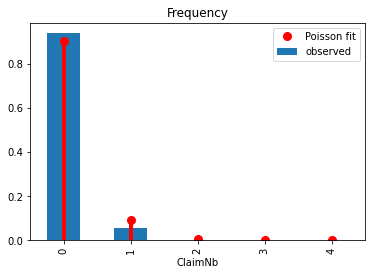

In [16]:
#df['ClaimNb'].plot(kind='hist', density = True)

df_plot = (
    df.loc[:, ['ClaimNb', 'Exposure']]
    .groupby('ClaimNb')
    .sum()
    .assign(Frequency_Observed = lambda x: x.Exposure / df['Exposure'].sum())
)

df_plot['Frequency_Observed'].plot(kind = 'bar', label='observed')

mean = df['ClaimNb'].sum() / df['Exposure'].sum()
x = range(5)
plt.plot(x, scipy.stats.poisson.pmf(x, mean), 'ro', ms=8, mec='r', label='Poisson fit')
plt.vlines(x=x, ymin=0, ymax=scipy.stats.poisson.pmf(x, mean), color='r', lw=4)
plt.xticks(x)
plt.legend()
plt.title("Frequency");

Not too bad, visually.

Next, we want to check the mean-variance relationship of the Poisson distribution: $\mathrm{Var}[Y] = \frac{\mathrm{E}[Y]}{Exposure}$. To to so, we choose the feature `VehPower`, because we hope that the frequency $Y$ depends very much on it. We then plot empirical estimates of $\mathrm{Var}[Y]$ vs $\mathrm{E}[Y]/Exposure$ for every value of `VehPower`.

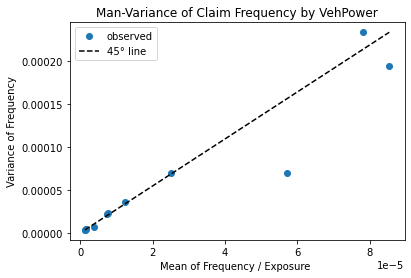

In [17]:
# Check mean-variance relationship for Poisson: Var[Y] = E[Y] / Exposure
# Estimate Var[Y] and E[Y]
# Plot estimates Var[Y] vs E[Y]/Exposure
# Note: We group by VehPower in order to have different E[Y].

def my_agg(x):
    """See https://stackoverflow.com/q/44635626"""
    names = {
        'Freq_mean': np.average(x['Freq'], weights=x['Exposure']),
        'Freq_var': var_weighted(x['Freq'], weights=x['Exposure'], method=2),
        'Exposure_sum': x['Exposure'].sum()
    }
    return pd.Series(names, index=['Freq_mean', 'Freq_var', 'Exposure_sum'])

df_plot = (df
           .assign(Freq = lambda x: x['ClaimNb']/x['Exposure'])
           .groupby('VehPower')
           .apply(my_agg)
          )

plt.plot(df_plot['Freq_mean']/df_plot['Exposure_sum'], df_plot['Freq_var'], '.',
         markersize=12, label='observed')

plt.plot([(df_plot['Freq_mean']/df_plot['Exposure_sum']).min(),
          (df_plot['Freq_mean']/df_plot['Exposure_sum']).max()],
         [df_plot['Freq_var'].min(), df_plot['Freq_var'].max()],
         'k--', label='45° line')
plt.xlabel('Mean of Frequency / Exposure ')
plt.ylabel('Variance of Frequency')
plt.legend()
plt.title('Man-Variance of Claim Frequency by VehPower');

This is a strong confirmation for the use of a Poisson when fitting!

Hints:
- If Y were normal distributed, one should see a horizontal line, because for a Normal: Var[Y] ~ constant/Exposure.
- The 45° line is not even necessary, any straight line through the origin would be enough for simple reasons:
    1. A quasi-Poisson distribution has $Var[Y] = \phi * E[Y]/w$ for some $\phi$.
    2. $\phi$ does not influence the estimation/fitting of E[Y] (thanks @[ExponentialDispersionFamily](https://en.wikipedia.org/wiki/Exponential_dispersion_model)).

### 4.2 Reproduce model GLM1 of the case study paper

R result on whole data set:

```R
Call:
glm(formula = ClaimNb ~ VehPowerGLM + VehAgeGLM + DrivAgeGLM + 
    BonusMalusGLM + VehBrand + VehGas + DensityGLM + Region + 
    AreaGLM, family = poisson(), data = dat2, offset = log(Exposure))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9002  -0.3784  -0.2894  -0.1630   6.8929  

Coefficients:
                Estimate Std. Error  z value Pr(>|z|)    
(Intercept)   -3.9869296  0.0366257 -108.856  < 2e-16 ***
VehPowerGLM5   0.1882444  0.0182221   10.331  < 2e-16 ***
VehPowerGLM6   0.2206928  0.0181219   12.178  < 2e-16 ***
VehPowerGLM7   0.1324376  0.0179406    7.382 1.56e-13 ***
VehPowerGLM8  -0.0729859  0.0270731   -2.696 0.007020 ** 
VehPowerGLM9   0.2132070  0.0200247   10.647  < 2e-16 ***
VehAgeGLM1     1.1663322  0.0162768   71.656  < 2e-16 ***
VehAgeGLM3    -0.2033232  0.0133646  -15.214  < 2e-16 ***
DrivAgeGLM1    0.0459512  0.0432388    1.063 0.287905    
DrivAgeGLM2   -0.3060585  0.0264092  -11.589  < 2e-16 ***
DrivAgeGLM3   -0.4285907  0.0219638  -19.513  < 2e-16 ***
DrivAgeGLM4   -0.2919377  0.0157723  -18.510  < 2e-16 ***
DrivAgeGLM6   -0.0704886  0.0142465   -4.948 7.51e-07 ***
DrivAgeGLM7    0.0020017  0.0224714    0.089 0.929020    
BonusMalusGLM  0.0230526  0.0003379   68.224  < 2e-16 ***
VehBrandB10    0.0081586  0.0370468    0.220 0.825696    
VehBrandB11    0.0896067  0.0396075    2.262 0.023675 *  
VehBrandB12    0.1231339  0.0175753    7.006 2.45e-12 ***
VehBrandB13    0.0570732  0.0410313    1.391 0.164236    
VehBrandB14   -0.1318432  0.0785812   -1.678 0.093387 .  
VehBrandB2     0.0011425  0.0153481    0.074 0.940659    
VehBrandB3     0.0004747  0.0219348    0.022 0.982734    
VehBrandB4     0.0003895  0.0298454    0.013 0.989587    
VehBrandB5     0.0717207  0.0249588    2.874 0.004059 ** 
VehBrandB6     0.0080993  0.0284873    0.284 0.776170    
VehGasRegular  0.0681720  0.0113837    5.989 2.12e-09 ***
DensityGLM     0.0313760  0.0120229    2.610 0.009062 ** 
RegionR11     -0.1237443  0.0233890   -5.291 1.22e-07 ***
RegionR21      0.0508008  0.0802838    0.633 0.526887    
RegionR22     -0.0100522  0.0493840   -0.204 0.838703    
RegionR23     -0.1388754  0.0586533   -2.368 0.017897 *  
RegionR25     -0.0521472  0.0412511   -1.264 0.206180    
RegionR26     -0.0800721  0.0457013   -1.752 0.079761 .  
RegionR31     -0.1790355  0.0320324   -5.589 2.28e-08 ***
RegionR41     -0.3070169  0.0422343   -7.269 3.61e-13 ***
RegionR42     -0.1097139  0.0877356   -1.251 0.211115    
RegionR43     -0.1765093  0.1330280   -1.327 0.184556    
RegionR52     -0.0784913  0.0249993   -3.140 0.001691 ** 
RegionR53      0.0215696  0.0221328    0.975 0.329781    
RegionR54     -0.1146011  0.0338761   -3.383 0.000717 ***
RegionR72     -0.1557227  0.0297364   -5.237 1.63e-07 ***
RegionR73     -0.1936586  0.0403100   -4.804 1.55e-06 ***
RegionR74      0.1204255  0.0632136    1.905 0.056773 .  
RegionR82      0.0085350  0.0187957    0.454 0.649761    
RegionR83     -0.3781741  0.0738928   -5.118 3.09e-07 ***
RegionR91     -0.1256964  0.0284714   -4.415 1.01e-05 ***
RegionR93     -0.0862625  0.0207796   -4.151 3.31e-05 ***
RegionR94      0.0607886  0.0652408    0.932 0.351462    
AreaGLM        0.0156128  0.0161290    0.968 0.333048    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 223932  on 678012  degrees of freedom
Residual deviance: 212603  on 677964  degrees of freedom
AIC: 282018

Number of Fisher Scoring iterations: 6
```

In [18]:
X = col_trans_GLM1.transform(df)
z = df['ClaimNb'].values
weight = df['Exposure'].values
# y = claims frequency
y = z / weight

In [19]:
# As a check, fit on the whole data and compare to R
glmcv = GeneralizedLinearRegressorCV(family='poisson', l1_ratio=[0, 0.25, 0.5, 0.75, 1], fit_intercept=True, max_iter=150)
glmcv.fit(X, y, sample_weight=weight)
print(glmcv.alpha_)
print(glmcv.l1_ratio_)

4.328761281083059
0.0


In [20]:
glm = GeneralizedLinearRegressor(family='poisson', alpha=glmcv.alpha_, l1_ratio=glmcv.l1_ratio_, fit_intercept=True, gradient_tol=1e-8) # QUESTION: change tol to gradient_tol or step_size_tol?
glm.fit(X, y, sample_weight=weight)
print(f"Number of iterations: {glm.n_iter_}")
pd.DataFrame({'coefficient': np.concatenate(([glm.intercept_], glm.coef_))},
             index=['intercept'] + col_trans_GLM1_names)

Number of iterations: 4


,coefficient
intercept,-3.403037
VehPower_5,0.000200
VehPower_6,0.000043
VehPower_7,-0.000073
VehPower_8,-0.000189
VehPower_9,0.000384
"VehAge_[0,1)",0.002270
"VehAge_(10,inf)",-0.001610
"DrivAge_[18,21)",0.000097
"DrivAge_[21,26)",-0.000049


**We have very good agreement to the R results!**

### 4.3 Frequency GLM with Train and Test Data
From now on, we use claim number with positive claim amount 'ClaimNb_pos' and we devide the dataset into training set and test set with a 9:1 random split.

In [21]:
z = df['ClaimNb_pos'].values
weight = df['Exposure'].values
# y = claims frequency
y = z / weight

ss = ShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train, test = next(ss.split(y))

f_glm1 = make_pipeline(col_trans_GLM1,
                       GeneralizedLinearRegressor(family='poisson', alpha=0, l1_ratio=1, fit_intercept=True))
f_glm1.fit(df.iloc[train], y[train], generalizedlinearregressor__sample_weight=weight[train]);

print('training loss f_glm1: {}'.format(
    poisson_deviance(y[train], f_glm1.predict(df.iloc[train]), sample_weight=weight[train])))

print('test loss f_glm1: {}'.format(
      poisson_deviance(y[test], f_glm1.predict(df.iloc[test]), sample_weight=weight[test])))

training loss f_glm1: 0.4568644480050643
test loss f_glm1: 0.4578960642944006


A GLM with canonical link function (Normal - identity, Poisson - log, Gamma - 1/x, Binomial - logit) with an intercept term has the so called **balance property**. Neglecting small deviations by the opimizer used for fitting, the results fulfil on the training sample:
$$\sum_{i \in training} w_i y_i = \sum_{i \in training} w_i \hat{\mu}_i$$
Summing up the predictions $\hat{\mu}_i$ yields exaclty the observations $y_i$. 

In [22]:
# balance property of GLM with canonical link, like log-link for Poisson:
z[train].sum(), (f_glm1.predict(df.iloc[train]) * weight[train]).sum()

(23785, 23785.018907792277)

In [23]:
# for Poisson deviance, note that the following are equivalent (with freq = count/weight)
# dev(observed count, predicted count) ~ dev(observed freq, predicted freq, sample_weight=weight)
print('training loss f_glm1: {}'.format(
    weight[train].sum()/len(train) * \
    poisson_deviance(y[train], f_glm1.predict(df.iloc[train]), sample_weight=weight[train])))

print('training loss f_glm1: {}'.format(
    poisson_deviance(z[train], f_glm1.predict(df.iloc[train]) * weight[train])))

print('testing loss f_glm1:  {}'.format(
    poisson_deviance(z[test], f_glm1.predict(df.iloc[test]) * weight[test])))

# Compare to test loss of Mean model
print('testing loss Mean:    {}'.format(
    poisson_deviance(z[test],
                     np.average(y[train], weights=weight[train])*weight[test])))

training loss f_glm1: 0.24148648910561918
training loss f_glm1: 0.24148648910561918
testing loss f_glm1:  0.24189892474652655
testing loss Mean:    0.25291674783430484


<ipython-input-4-d7991f578cef>:39: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_ = (df_.groupby([feature])['weight', 'observed', 'predicted']
/Users/mabasta/opt/anaconda3/envs/quantcore.glm/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
<ipython-input-4-d7991f578cef>:39: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_ = (df_.groupby([feature])['weight', 'observed', 'predicted']
/Users/mabasta/opt/anaconda3/envs/quantcore.glm/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be

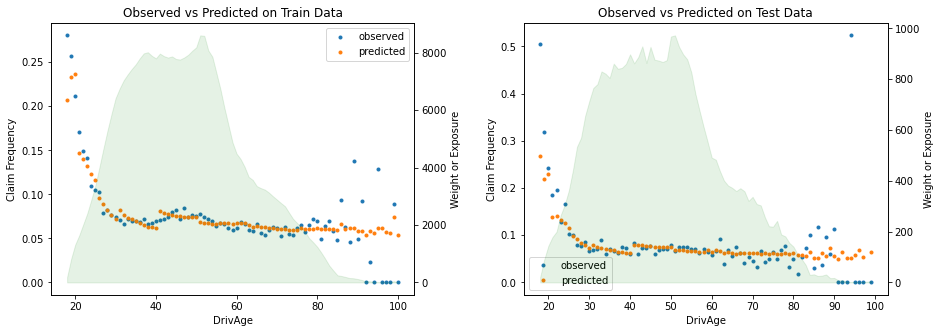

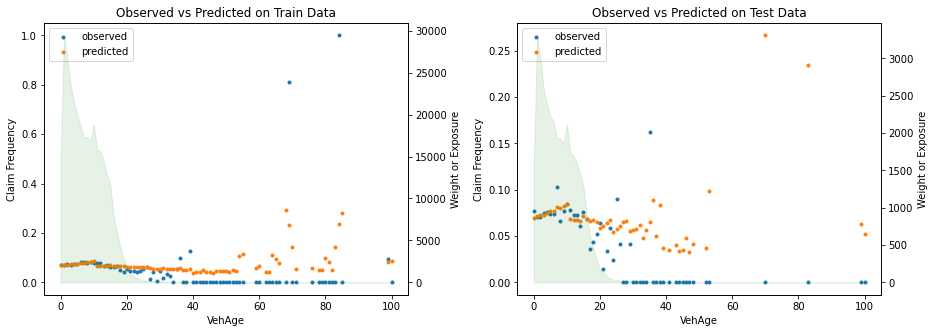

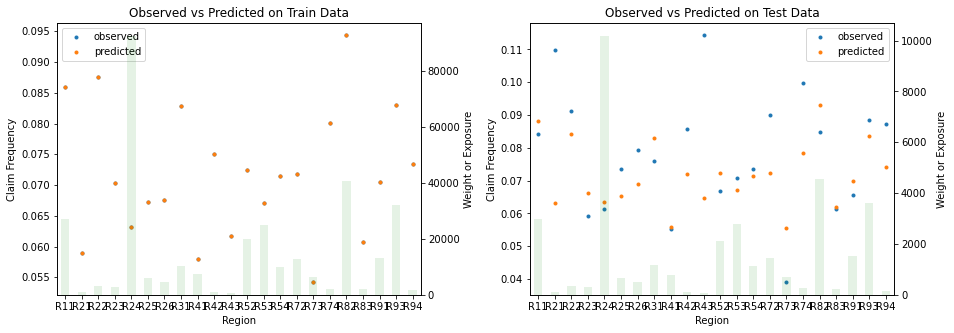

In [24]:
df_plot = df.copy()
df_plot['Freq_Observed'] = df_plot['ClaimNb_pos'] / df_plot['Exposure']
df_plot['Freq_Predicted'] = f_glm1.predict(df)

# plot DivAge
# Note: with just one plt.subplots(ncols=2, nrows=3, figsize=(16, 6)) the x-axis label disappears
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
fig.subplots_adjust(wspace=0.3)
plot_obs_pred(df_plot.iloc[train], 'DrivAge', 'Freq_Observed', 'Freq_Predicted', 'Exposure',
              y_label='Claim Frequency', title='Observed vs Predicted on Train Data', ax=axes[0])

plot_obs_pred(df_plot.iloc[test], 'DrivAge', 'Freq_Observed', 'Freq_Predicted', 'Exposure',
              y_label='Claim Frequency', title='Observed vs Predicted on Test Data', ax=axes[1])

# plot VehAge
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
fig.subplots_adjust(wspace=0.3)
plot_obs_pred(df_plot.iloc[train], 'VehAge', 'Freq_Observed', 'Freq_Predicted', 'Exposure',
              y_label='Claim Frequency', title='Observed vs Predicted on Train Data', ax=axes[0])

plot_obs_pred(df_plot.iloc[test], 'VehAge', 'Freq_Observed', 'Freq_Predicted', 'Exposure',
              y_label='Claim Frequency', title='Observed vs Predicted on Test Data', ax=axes[1])

# plot Region
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
fig.subplots_adjust(wspace=0.3)
plot_obs_pred(df_plot.iloc[train], 'Region', 'Freq_Observed', 'Freq_Predicted', 'Exposure',
              y_label='Claim Frequency', title='Observed vs Predicted on Train Data',
              kind_weight='bar', ax=axes[0])

plot_obs_pred(df_plot.iloc[test], 'Region', 'Freq_Observed', 'Freq_Predicted', 'Exposure',
              y_label='Claim Frequency', title='Observed vs Predicted on Test Data',
              kind_weight='bar', ax=axes[1])

Before we fit more complicated frequency models, we come to the severity model.

## 5 Severity GLM -  Gamma Distribution <a class="anchor" id="5-severity"></a>
[back to Table of Contents](#toc)

We fit a GLM model for the severity with the same features as the freq model.
The severity $y$ is the average claim size.
We define:
- $z$: total claim amount, single claims cut at 100_000
- $w$: number of claims (with positive claim amount!)
- $y = \frac{z}{w}$: severity

### 5.1 Why Gamma distributions
The severity $y$ is a positive, real number, $y \in (0, \infty)$. Theoretically, especially for liability claims, one could have arbitrary large numbers&mdash;very unlikely but possible. A very simple distribution for this range is an Exponential distribution, or its generalization, a Gamma distribution $y \sim Gamma$. In the insurance industry, it is well known that the severity might be skewed and have heavy tails, i.e. a few very large losses, as does our dataset. That's why we only analyse the claim amount cut at 100'000.

A Gamma distribution has mean-variance relation $\mathrm{Var}[Y] = \frac{\phi}{w} \mathrm{E}[Y]^2$. Note that the dispersion $\phi$ does not influence the estimation of $E[\mu]$.

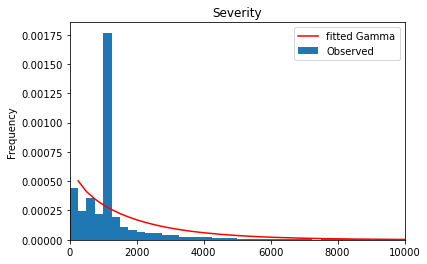

In [25]:
df_plot = (
    df.loc[:, ['ClaimAmountCut', 'ClaimNb_pos']]
    .query('ClaimNb_pos > 0')
    .assign(Severity_Observed = lambda x: x['ClaimAmountCut'] / df['ClaimNb_pos'])
)

df_plot['Severity_Observed'].plot.hist(bins=400, density=True, label='Observed', )

x = np.linspace(0, 1e5, num=400)
plt.plot(x,
         scipy.stats.gamma.pdf(x, *scipy.stats.gamma.fit(df_plot['Severity_Observed'], floc=0)),
         'r-', label='fitted Gamma')
plt.legend()
plt.title("Severity");
plt.xlim(left=0, right = 1e4);
#plt.xticks(x);

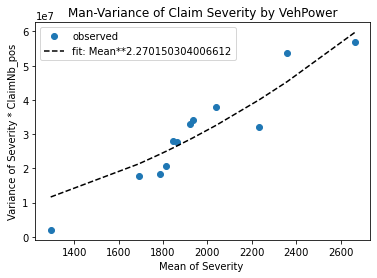

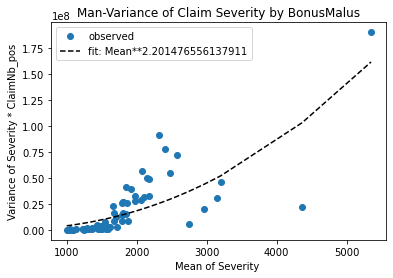

In [26]:
# Check mean-variance relationship for Gamma: Var[Y] = E[Y]^2 / Exposure
# Estimate Var[Y] and E[Y]
# Plot estimates Var[Y] vs E[Y]^s/Exposure
# Note: We group by VehPower and BonusMalus in order to have different E[Y].

def my_agg(x):
    """See https://stackoverflow.com/q/44635626"""
    names = {
        'Sev_mean': np.average(x['Sev'], weights=x['ClaimNb_pos']),
        'Sev_var': var_weighted(x['Sev'], weights=x['ClaimNb_pos'], method=1),
        'ClaimNb_pos_sum': x['ClaimNb_pos'].sum()
    }
    return pd.Series(names, index=['Sev_mean', 'Sev_var', 'ClaimNb_pos_sum'])

for col in ['VehPower', 'BonusMalus']:
    claims = df.groupby(col)['ClaimNb_pos'].sum()
    df_plot = (df.loc[df[col].isin(claims[claims >= 4].index), :]
               .query('ClaimNb_pos > 0')
               .assign(Sev = lambda x: x['ClaimAmountCut']/x['ClaimNb_pos'])
               .groupby(col)
               .apply(my_agg)
              )

    plt.plot(df_plot['Sev_mean'], df_plot['Sev_var'] * df_plot['ClaimNb_pos_sum'], '.',
             markersize=12, label='observed')

    # fit: mean**p/claims
    p = optimize.curve_fit(lambda x, p: np.power(x, p),
                           df_plot['Sev_mean'].values,
                           df_plot['Sev_var'] * df_plot['ClaimNb_pos_sum'],
                           p0 = [2])[0][0]
    df_fit = pd.DataFrame({'x': df_plot['Sev_mean'],
                           'y': np.power(df_plot['Sev_mean'], p)})
    df_fit = df_fit.sort_values('x')

    plt.plot(df_fit.x, df_fit.y,
             'k--', label='fit: Mean**{}'.format(p))
    plt.xlabel('Mean of Severity ')
    plt.ylabel('Variance of Severity * ClaimNb_pos')
    plt.legend()
    plt.title('Man-Variance of Claim Severity by {}'.format(col))
    plt.show()

This is good empirical confirmation to use the Gamma.

Note: The data seems to be slightly heavier tailed than a Gamma, because estimated p > 2 (it is 2.27 or 2.20). The second plot with BonusMalus might even suggest 2 different regions, on region from 0 to 1'800 and another from 1'800 upwards.

Hint: If Y were normal distributed, one should see a horizontal line, because $Var[Y] \sim constant/Exposure$
       and the fit should give $p \approx 0$.

### 5.2 Severity GLM with Train and Test Data
We fit a GLM model for the severity with the same features as the freq model.

Note:
- We filter out ClaimAmount == 0 as the Gamma distribution as support on $(0, \infty)$ not $[0, \infty)$
- We use ClaimNb_pos as sample weights.
- We use the same split in train and test data such that we can predict the final claim amount on the test set.

In [27]:
idx = df['ClaimAmountCut'].values > 0

z = df['ClaimAmountCut'].values
weight = df['ClaimNb_pos'].values
# y = claims severity
y = np.zeros_like(z)  # zeros will never be used
y[idx] = z[idx] / weight[idx]

# we also need to represent train and test as boolean indices
itrain = np.zeros(y.shape, dtype='bool')
itest = np.zeros(y.shape, dtype='bool')
itrain[train] = True
itest[test] = True
# simplify life
itrain = idx & itrain
itest = idx & itest

In [28]:
s_glm1 = make_pipeline(col_trans_GLM1,
                       GeneralizedLinearRegressor(family='gamma', alpha=0, l1_ratio=1, fit_intercept=True)
                      )
s_glm1.fit(df.iloc[itrain], y[itrain], generalizedlinearregressor__sample_weight=weight[itrain])

pd.DataFrame({'coefficient': np.concatenate(([s_glm1[-1].intercept_], s_glm1[-1].coef_))},
             index=['intercept'] + col_trans_GLM1_names)

,coefficient
intercept,7.211677
VehPower_5,-0.087185
VehPower_6,0.078803
VehPower_7,0.015877
VehPower_8,-0.037157
VehPower_9,0.055670
"VehAge_[0,1)",0.058692
"VehAge_(10,inf)",-0.025440
"DrivAge_[18,21)",0.502317
"DrivAge_[21,26)",0.049736


In [29]:
print('training loss s_glm1: {}'.format(
    gamma_deviance(y[itrain], s_glm1.predict(df.iloc[itrain]), sample_weight=weight[itrain])))

print('testing loss s_glm1:  {}'.format(
    gamma_deviance(y[itest], s_glm1.predict(df.iloc[itest]), sample_weight=weight[itest])))

print('testing loss Mean:    {}'.format(
    gamma_deviance(y[itest],
                   np.average(z[itrain], weights=weight[itrain])*np.ones_like(z[itest]),
                   sample_weight=weight[itest])))

# Overfit?

training loss s_glm1: 1.2916117794855915
testing loss s_glm1:  1.2997562479641365
testing loss Mean:    1.3115309309577132


<ipython-input-4-d7991f578cef>:39: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_ = (df_.groupby([feature])['weight', 'observed', 'predicted']
/Users/mabasta/opt/anaconda3/envs/quantcore.glm/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
<ipython-input-4-d7991f578cef>:39: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_ = (df_.groupby([feature])['weight', 'observed', 'predicted']
/Users/mabasta/opt/anaconda3/envs/quantcore.glm/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be

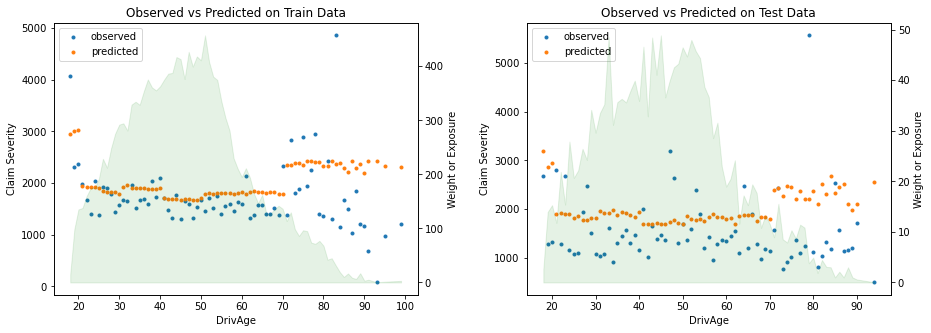

In [30]:
df_plot = df.copy()
df_plot['Sev_Observed'] = 0
df_plot.loc[idx, 'Sev_Observed'] = df_plot.loc[idx, 'ClaimAmountCut'] / df_plot.loc[idx, 'ClaimNb_pos']
df_plot['Sev_Predicted'] = s_glm1.predict(df)

# plot DivAge
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
fig.subplots_adjust(wspace=0.3)
plot_obs_pred(df_plot.loc[itrain], 'DrivAge', 'Sev_Observed', 'Sev_Predicted', 'Exposure',
              y_label='Claim Severity', title='Observed vs Predicted on Train Data', ax=axes[0])

plot_obs_pred(df_plot.iloc[itest], 'DrivAge', 'Sev_Observed', 'Sev_Predicted', 'Exposure',
              y_label='Claim Severity', title='Observed vs Predicted on Test Data', ax=axes[1])

We put together the prediction of frequency and severity to get the predictions of the total claim amount per policy.

In [31]:
#Put together freq * sev together
print("Total claim amount on train set, observed = {}, predicted = {}".
     format(df['ClaimAmountCut'].values[train].sum(),
            np.sum(df['Exposure'].values[train] * f_glm1.predict(df.iloc[train]) * s_glm1.predict(df.iloc[train])))
     )

print("Total claim amount on test set, observed = {}, predicted = {}".
     format(df['ClaimAmountCut'].values[test].sum(),
            np.sum(df['Exposure'].values[test] * f_glm1.predict(df.iloc[test]) * s_glm1.predict(df.iloc[test])))
     )

Total claim amount on train set, observed = 44594644.68, predicted = 44582479.85559453
Total claim amount on test set, observed = 4707551.37, predicted = 4952516.721798855


In [32]:
#TODO: Evaluate Metric for Claim Amount on test set. Which metric? Tweedie p=1.5? Squared error?

#TODO: QQ-Plot for distributions

## 6 Geoinformation <a class="anchor" id="6-geoinfo"></a>
[back to Table of Contents](#toc)

One interesting aspect of our dataset is the presence of the feature `Region`. This is the [french Region](https://fr.wikipedia.org/wiki/R%C3%A9gion_fran%C3%A7aise) before 2016. For nice plots with a map of France, we downloaded the shapefile "Export de mars 2014 - vérifié et simplifié à 100m" from
<br>
https://www.data.gouv.fr/fr/datasets/contours-des-regions-francaises-sur-openstreetmap/
<br>
We use [geopandas](http://geopandas.org) to handel this. Let's have a look.

In [33]:
gdf_france = geopd.read_file("regions-20140306-100m-shp/regions-20140306-100m.shp")
gdf_france.head()

,code_insee,nom,nom_cl,insee_cl,nuts2,iso3166_2,wikipedia,nb_dep,nb_comm,surf_km2,geometry
0,42,Alsace,Strasbourg,67482,FR42,None,fr:Alsace,2,904,8328.0,"POLYGON ((7.43003 47.45949, 7.42880 47.45388, ..."
1,72,Aquitaine,Bordeaux,33063,FR61,None,fr:Aquitaine,5,2296,41818.0,"MULTIPOLYGON (((-1.75633 43.38372, -1.75590 43..."
2,83,Auvergne,Clermont-Ferrand,63113,FR72,None,fr:Auvergne,4,1310,26172.0,"POLYGON ((3.33690 44.95609, 3.31531 44.94425, ..."
3,25,Basse-Normandie,Caen,14118,FR25,None,fr:Basse-Normandie,3,1812,17786.0,"MULTIPOLYGON (((-1.51504 48.66027, -1.51304 48..."
4,26,Bourgogne,Dijon,21231,FR26,None,fr:Bourgogne,4,2046,31752.0,"POLYGON ((4.76293 46.17583, 4.75864 46.17205, ..."


<AxesSubplot:>

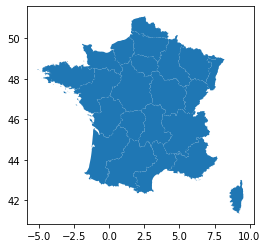

In [34]:
# filter out over-see regions
gdf_france = gdf_france[~gdf_france["nom"].isin(["Guadeloupe", "Guyane", "La Réunion", "Martinique", "Mayotte"])]
# define region to match the insurance data set
gdf_france['Region'] = "R" + gdf_france['code_insee']
# plot
gdf_france.plot()

In [35]:
# Check that the regions match
set(gdf_france['Region']) == set(df['Region'])

True

Let's plot `Exposure` and frequency on that map.

<ipython-input-36-9e7b1f01658c>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tmp = (df.groupby(['Region'])['Exposure', 'ClaimNb']
<ipython-input-36-9e7b1f01658c>:11: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  tmp.apply(lambda x: axes[0].annotate(s=x['Region'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1);
<ipython-input-36-9e7b1f01658c>:12: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  tmp.apply(lambda x: axes[1].annotate(s=x['Region'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1);


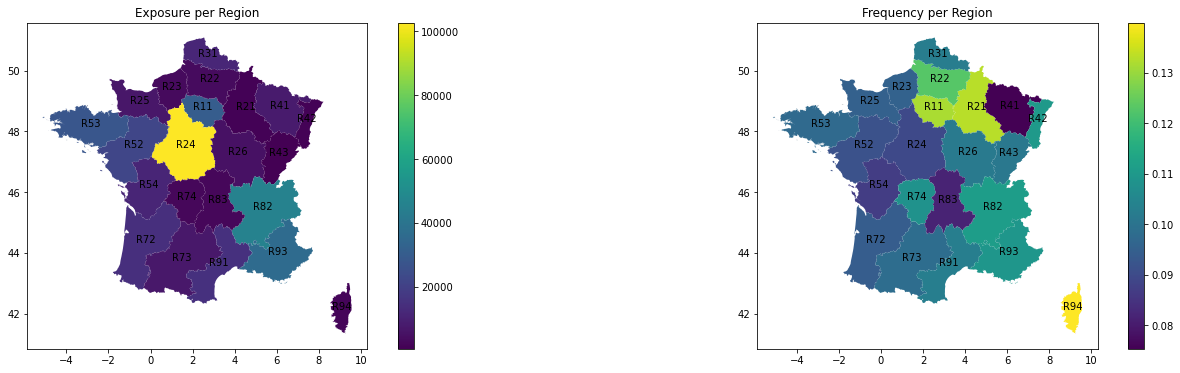

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12*2, 6))

tmp = (df.groupby(['Region'])['Exposure', 'ClaimNb']
          .sum()
          .assign(frequency = lambda x: x['ClaimNb']/x['Exposure'])
         )
tmp = gdf_france.merge(tmp, on='Region', how='right')
# https://stackoverflow.com/questions/38899190/geopandas-label-polygons
tmp.plot(column='Exposure', legend=True, ax=axes[0])
tmp.plot(column='frequency', legend=True, ax=axes[1])
tmp.apply(lambda x: axes[0].annotate(s=x['Region'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1);
tmp.apply(lambda x: axes[1].annotate(s=x['Region'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1);
axes[0].set_title('Exposure per Region');
axes[1].set_title('Frequency per Region');

Who would have guessed that Corsica has the highest claims frequency?!

Before we apply spatial smoothing, we start simpler with an L2 penalty on the coefficiencs of the region.
$$penalty = ||\beta_{\text{Region}}||_2^2$$
This is also known as Ridge regression. One can pass a vector `P2` to `GeneralizedLinearRegressor` in order to exclude certain features from being penalized.

Note that we now use a preprocessing pipeline without dropping the reference categories and with standardizing the numerical features.

In [37]:
# Hint for Choice of vmin and vmax of plot above
(pd.DataFrame({'coefficient': f_glm1[-1].coef_},
              index=col_trans_GLM1_names)
 .loc['Region_R11':'Region_R94']
 .describe()
)
# min = -0.187431
# max = 0.324941

,coefficient
count,21.000000
mean,0.025800
std,0.116762
min,-0.187431
25%,-0.028890
50%,0.011002
75%,0.055581
max,0.324941


alpha = 0.0001, poisson deviance on test = 0.45791411640788243
alpha = 0.001, poisson deviance on test = 0.4581297138115914
alpha = 0.01, poisson deviance on test = 0.4593143434839707
alpha = 0.1, poisson deviance on test = 0.4652509485755332


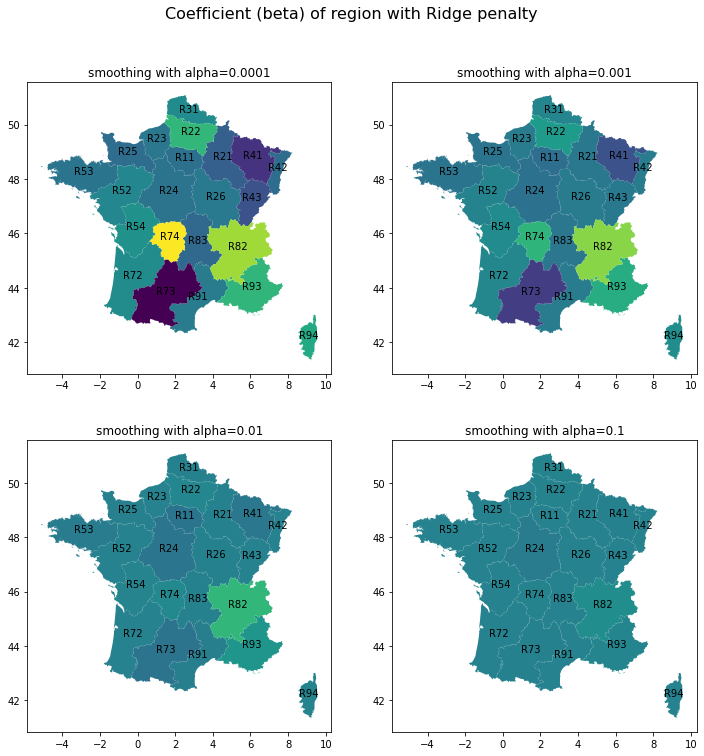

In [38]:
# Note: For the plot, use sensible vmin, vmax.

z = df['ClaimNb_pos'].values
weight = df['Exposure'].values
# y = claims frequency
y = z / weight

col_trans_2, col_trans_2_names  = gen_col_trans(drop=False, standardize=True)

n_features = len(col_trans_2_names)
offset = col_trans_2_names.index('Region_R11')

P2 = np.ones(n_features)

f_glm_ridge = make_pipeline(col_trans_2,
                            GeneralizedLinearRegressor(family='poisson', alpha=0.01, P2 = P2,
                                                       l1_ratio = 0, fit_intercept=True,
                                                       warm_start=True))

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 16))
fig.suptitle("Coefficient (beta) of region with Ridge penalty",
             y=0.85, fontsize=16)
fig.subplots_adjust(hspace=-0.3)
for i, alpha in enumerate([1e-4, 1e-3, 1e-2, 1e-1]):
    ax = axes[i//2, i%2]
    f_glm_ridge.set_params(generalizedlinearregressor__alpha=alpha)
    f_glm_ridge.fit(df.iloc[train], y[train], generalizedlinearregressor__sample_weight=weight[train])
    coef_geo = f_glm_ridge[-1].coef_[offset:offset+22]
    gdf_tmp = gdf_france.copy()
    gdf_tmp = gdf_tmp.merge(pd.DataFrame({'coef': coef_geo,
                                          'Region': col_trans_2.transformers_[7][1].categories_[0]}),
                            on='Region', how='left')
    gdf_tmp.plot(column='coef', ax = ax, vmin=-0.2, vmax=0.25)
    gdf_tmp.apply(lambda x: ax.annotate(text=x['Region'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1);
    ax.set_title('smoothing with alpha={}'.format(alpha))
    print('alpha = {}, poisson deviance on test = {}'
          .format(alpha,
                  poisson_deviance(y[test], f_glm_ridge.predict(df.iloc[test]), sample_weight=weight[test])))

Now, we will use the geographical information for smoothing to the nearest neighbour. Therefore, we need to construct a penalty matrix $P$ such that for neighbouring regions, e.g. for R11 and R24, we have
$$\begin{pmatrix} \beta_{R11}, \beta_{R24}\end{pmatrix} P \begin{pmatrix} \beta_{R11} \\ \beta_{R24}\end{pmatrix}
= (\beta_{R11} - \beta_{R24})^2$$
This hold, for example, with $P = \begin{pmatrix} 1 & -1 \\ -1 & 1\end{pmatrix}$. We construct this matrix $P$ by hand even though there exist libraries for automating this, e.g. [pysal](http://pysal.org), [pysal.lib.weights.Queen](http://pysal.org/pysal/generated/pysal.lib.weights.Queen.html#pysal-lib-weights-queen).

In [39]:
# Construct adjacency or contiguity matrix
# Could use pysal, but lots of dependencies => do it manually
# We have 22 regions:
# np.unique(gdf_france['Region'])
region2index = dict(zip(np.unique(gdf_france['Region']), range(22)))
P_region = \
[['R11', 'R21'],
 ['R11', 'R22'],
 ['R11', 'R23'],
 ['R11', 'R24'],
 ['R11', 'R26'],
 
 ['R21', 'R22'],
 ['R21', 'R26'],
 ['R21', 'R41'],
 ['R21', 'R43'],
 
 ['R22', 'R23'],
 ['R22', 'R31'],

 ['R23', 'R24'],
 ['R23', 'R25'],
 
 ['R24', 'R25'],
 ['R24', 'R26'],
 ['R24', 'R52'],
 ['R24', 'R54'],
 ['R24', 'R74'],
 ['R24', 'R83'],
 
 ['R25', 'R52'],
 ['R25', 'R53'],
 
 ['R26', 'R43'],
 ['R26', 'R82'],
 ['R26', 'R83'],
 
 ['R41', 'R42'],
 ['R41', 'R43'],
 
 ['R42', 'R43'],
 
 ['R43', 'R82'],
 
 ['R52', 'R53'],
 ['R52', 'R54'],
 
 ['R54', 'R72'],
 ['R54', 'R74'],
 
 ['R72', 'R73'],
 ['R72', 'R74'],
 
 ['R73', 'R74'],
 ['R73', 'R83'],
 ['R73', 'R91'],
 
 ['R74', 'R83'],
 
 ['R82', 'R83'],
 ['R82', 'R91'],
 ['R82', 'R93'],
 
 ['R83', 'R91'],
 
 ['R91', 'R93']
 
 # no neighbour for Corsica
]
P = np.zeros((22, 22))
for i, j  in P_region:
    P[region2index[i], region2index[i]] += 1
    P[region2index[j], region2index[j]] += 1
    P[region2index[i], region2index[j]] -= 1
    P[region2index[j], region2index[i]] -= 1

alpha = 1e-05, poisson deviance on test = 0.4579029050893881
alpha = 0.0001, poisson deviance on test = 0.45799588210089504
alpha = 0.001, poisson deviance on test = 0.4582560889822106
alpha = 0.01, poisson deviance on test = 0.4594547191177709


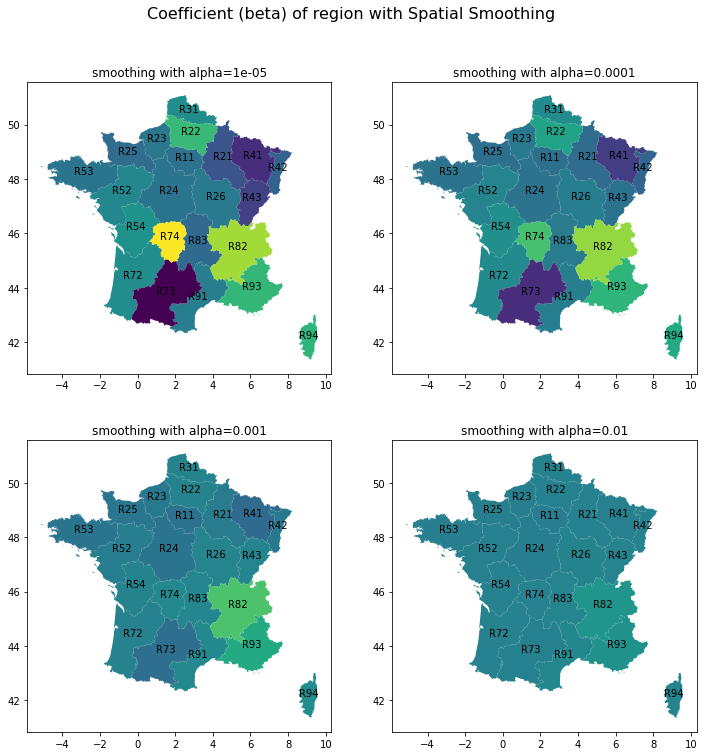

In [40]:
# Note: For the plot, use sensible vmin, vmax.

n_features = len(col_trans_2_names)

P2 = np.eye(n_features, n_features)
offset = col_trans_2_names.index('Region_R11')
# Also add L2 (Ridge) penalty on Region to avoid single matrix errors due to not dropping one hot encoded columns
# otherwise the "niveau" of coef_region gets unstable.
P2[offset:(offset+22), offset:(offset+22)] += P


f_glm_geo = make_pipeline(col_trans_2,
                          GeneralizedLinearRegressor(family='poisson', alpha=0.01,  P2=P2,
                                                     l1_ratio = 0, fit_intercept=True,
                                                     warm_start=True))

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 16))
fig.suptitle("Coefficient (beta) of region with Spatial Smoothing",
             y=0.85, fontsize=16)
fig.subplots_adjust(hspace=-0.3)
for i, alpha in enumerate([1e-5, 1e-4, 1e-3, 1e-2]):
    ax = axes[i//2, i%2]
    f_glm_geo.set_params(generalizedlinearregressor__alpha=alpha)
    f_glm_geo.fit(df.iloc[train], y[train], generalizedlinearregressor__sample_weight=weight[train])
    coef_geo = f_glm_geo[-1].coef_[offset:offset+22]
    gdf_tmp = gdf_france.copy()
    gdf_tmp = gdf_tmp.merge(pd.DataFrame({'coef': coef_geo, 'Region': col_trans_2.transformers_[7][1].categories_[0]}),
                            on='Region', how='left')
    gdf_tmp.plot(column='coef', ax = ax, vmin=-0.2, vmax=0.25)
    gdf_tmp.apply(lambda x: ax.annotate(text=x['Region'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1);
    ax.set_title('smoothing with alpha={}'.format(alpha))
    print('alpha = {}, poisson deviance on test = {}'
          .format(alpha,
                  poisson_deviance(y[test], f_glm_geo.predict(df.iloc[test]), sample_weight=weight[test])))

In [41]:
# Compared to GLM1:
poisson_deviance(y[test], f_glm1.predict(df.iloc[test]), sample_weight=weight[test])

0.4578960642944006

We note that **spatial smoothing of the coefficients of a GLM is possible**. In our case, the smoother the result, the more predictive power we loose. There might be a compromise for a spatial smoothing with low penalty alpha.

We also see not much of a difference to the Ridge penalty above. Note, however, that we chose different penalty parameters alpha (10 times stronger for Ridge than for geo smooth). Have a close look at region R74 and R73. They are neighbours but have quite different observed frequencies. This is in contradiction to our implicit assumption with the spatial penalties: Neighbours behave similarly. This could be tested with geospatial statistics (keyword semivariogram). Also, the spatial division into regions might be too coarse. Smaller administative regions like the *French départements* might give better results, but such data is unfortunately unavailable.

## TODO: Frequency ElasticNet

In [42]:
# elastic net
#ct_enet, cn_enet = gen_col_trans(drop=False)
#ct_enet.fit(insurance_data);
#X2 = ct_enet.transform(insurance_data)
#
#glm2 = GeneralizedLinearRegressor(family='poisson', alpha=0.5, l1_ratio=0.9, fit_intercept=True,
#                                 tol=1e-3)
#glm2.fit(X2[train], y[train], sample_weight=weight[train])

In [43]:
#print('in-sample loss: {}'.format(
#    poisson_deviance(z[train], glm.predict(X[train], sample_weight=weight[train]))))
#
#print('out-of-sample loss: {}'.format(
#    poisson_deviance(z[test], glm.predict(X[test], sample_weight=weight[test]))))
#
#print('in-sample loss: {}'.format(
#    poisson_deviance(z[train], glm2.predict(X2[train], sample_weight=weight[train]))))
#
#print('out-of-sample loss: {}'.format(
#    poisson_deviance(z[test], glm2.predict(X2[test], sample_weight=weight[test]))))

In [44]:
# pf = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
# X3 = VarianceThreshold().fit_transform(
#     StandardScaler().fit_transform(
#         pf.fit_transform(X2.toarray())))

# glm3 = GeneralizedLinearRegressor(family='poisson', alpha=1, l1_ratio=0.9, fit_intercept=True,
#                                   tol=1e-3)
# glm3.fit(X3[train], y[train], sample_weight=weight[train])

# print('in-sample loss: {}'.format(
#     poisson_deviance(z[train], glm3.predict(X3[train], sample_weight=weight[train]))))

# print('out-of-sample loss: {}'.format(
#     poisson_deviance(z[test], glm3.predict(X3[test], sample_weight=weight[test]))))

In [45]:
# pf = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
# X3 = VarianceThreshold().fit_transform(
#     StandardScaler().fit_transform(
#         pf.fit_transform(X2.toarray)))
# glm3 = GeneralizedLinearRegressor(family='poisson', alpha=1, l1_ratio=0.9, fit_intercept=True,
#                                   tol=1e-3)
# glm3.fit(X3[train], y[train], sample_weight=weight[train])

# print('in-sample loss: {}'.format(
#     poisson_deviance(z[train], glm3.predict(X3[train], sample_weight=weight[train]))))

# print('out-of-sample loss: {}'.format(
#     poisson_deviance(z[test], glm3.predict(X3[test], sample_weight=weight[test]))))

In [46]:
# VarianceThreshold().fit_transform(
#     StandardScaler().fit_transform(
#         pf.fit_transform(X2.toarray()))).shape